# 빅데이터처리
## Week06_Quiz
### 2016003709 윤가영

In [1]:
# To find out where the pyspark
import findspark
findspark.init()

In [2]:
# Creating Spark Context
from pyspark import SparkContext
sc = SparkContext("local", "first app")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

In [4]:
def create_setdata(ss):
    record = set()
    for i in ss:
        if i not in record:
            record.add(i)
        else:
            yield record
            record = set()
    if not record:
        yield record

In [5]:
def create_dataset(N):
    """
    N개의 집합 데이터 생성 (D = 사전 사이즈)
    """
    
    while True:
        s = np.random.default_rng().zipf(1.2, N*10*10)
        dataset = list(create_setdata(s[s<N]))
        if len(dataset) >= N:
            break
        
    ids = range(N)
    return [(i, s) for i, s in zip(ids, dataset[:N])]

In [6]:
def add(x,y):
    return x+y

#### outgoing link가 없어 사라진 node 추가하는 함수

In [7]:
def maker(itr, N):
    for i in range(N):
        flag = 0
        for it in itr:
            if(i == it[0]):
                flag = 1
                break
        if(flag == 0):
            itr.append((i,0))
    return itr

#### Quiz 해답

In [8]:
def Quiz1(dataset, N, d, convergenceTol):
    start = time.time()
    
    pr = sc.broadcast([ 1. / float(N) for _ in range(N) ])
    inputRDD = sc.parallelize(dataset).cache()
    
    while True:
        itr = inputRDD.flatMap(lambda t: [ (target, pr.value[t[0]] / len(t[1])) for target in t[1] ]) 
        itr = itr.reduceByKey(add).collect()
        itr = sorted(maker(itr, N))
        itr = sc.parallelize(itr).mapValues(lambda v: d*v + 1/N * (1-d)).cache()
        
        # test convergence
        err = itr.map(lambda t: abs(pr.value[t[0]] - t[1])).sum() / N
        if err < convergenceTol:
            pr = itr.map(lambda t: t[1]).collect()
            break
        
        # broacast current pagerank values
        pr = sc.broadcast(itr.map(lambda t: t[1]).collect())
    
    end = time.time()
    return end - start

#### Quiz 실행코드

In [9]:
X = [4, 1000, 2000, 4000, 8000, 16000]

In [10]:
durations = []
for i in range(6):
    print("[Dataset: {}]".format(X[i]))
    print()
    
    dataset = create_dataset(X[i])
    duration = Quiz1(dataset, X[i], 0.85, 0.05)

    print("duration : {}".format(duration))
    print()

    durations.append(duration)

[Dataset: 4]

duration : 4.517955303192139

[Dataset: 1000]

duration : 0.9830420017242432

[Dataset: 2000]

duration : 1.2023205757141113

[Dataset: 4000]

duration : 2.920482635498047

[Dataset: 8000]

duration : 10.3979811668396

[Dataset: 16000]

duration : 31.52363657951355



#### 그래프

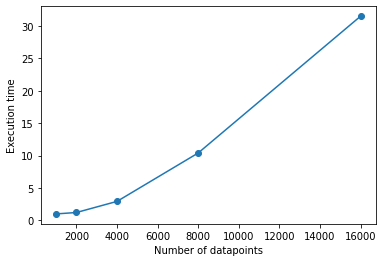

In [11]:
plt.plot(X[1:], durations[1:], marker = 'o')
plt.xlabel("Number of datapoints")
plt.ylabel("Execution time")

plt.show()